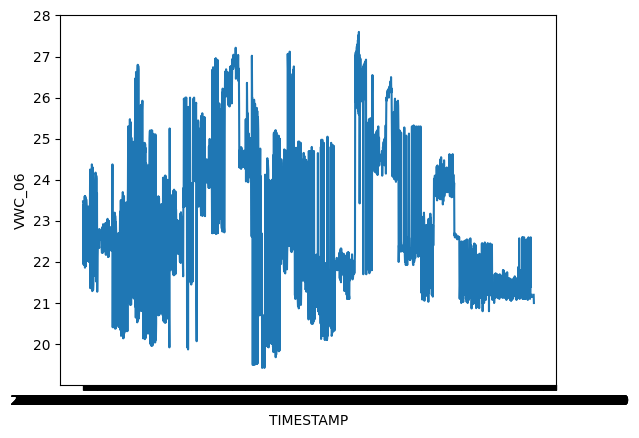

Number of missing values:  1427
Missing timestamps: 4        2023-08-24 23:00:00
6        2023-08-25 00:00:00
7        2023-07-30 07:00:00
12       2023-08-25 01:00:00
14       2023-07-30 06:00:00
                ...         
37526    2023-07-26 14:00:00
37529    2023-08-07 14:00:00
37532    2023-08-17 14:00:00
37535    2023-08-27 14:00:00
37538    2023-09-05 14:00:00
Name: TIMESTAMP, Length: 879, dtype: object
      VWC_06    VWC_18    VWC_30    VWC_42   day_sin   day_cos  hour_sin  \
4   0.520205  0.493258  0.335655  0.229572 -0.796183 -0.605056 -0.258819   
6   0.520205  0.493258  0.335655  0.221790 -0.806480 -0.591261  0.000000   
7   0.323284  0.265436  0.316656  0.800000 -0.471160 -0.882048  0.965926   
12  0.510584  0.493258  0.335655  0.233463 -0.806480 -0.591261  0.258819   
14  0.331623  0.265436  0.314756  0.807004 -0.471160 -0.882048  1.000000   

        hour_cos   dow_sin   dow_cos  
4   9.659258e-01  0.433884 -0.900969  
6   1.000000e+00 -0.433884 -0.900969  
7  -2.58819

In [22]:
# Imports for data handling and processing
import sqlite3
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Connect to the database and load data
conn = sqlite3.connect('processed_data.db')
query = 'SELECT * from data_table'
df = pd.read_sql_query(query, conn)
conn.close()

# select plot_number 2014
df = df[df['plot_number'] == 2014]

# select data between July 19 and September 06
df = df[(df['TIMESTAMP'] >= '2023-07-19') & (df['TIMESTAMP'] <= '2023-09-06')]

# print number of missing values
print("Number of missing values: ", df.isnull().sum().sum())

#print timestamps of missing values beside the missing values
print(f"Missing timestamps: {df[df.isnull().any(axis=1)]['TIMESTAMP']}")

# Timestamp cyclical encoding for day of year
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df['day_sin'] = np.sin(df['TIMESTAMP'].dt.dayofyear / 365 * 2 * np.pi)
df['day_cos'] = np.cos(df['TIMESTAMP'].dt.dayofyear / 365 * 2 * np.pi)

# Timestamp cyclical encoding for hour of day
df['hour_sin'] = np.sin(df['TIMESTAMP'].dt.hour / 24 * 2 * np.pi)
df['hour_cos'] = np.cos(df['TIMESTAMP'].dt.hour / 24 * 2 * np.pi)

# Timestamp cyclical encoding for day of week
df['dow_sin'] = np.sin(df['TIMESTAMP'].dt.dayofweek / 7 * 2 * np.pi)
df['dow_cos'] = np.cos(df['TIMESTAMP'].dt.dayofweek / 7 * 2 * np.pi)


# Normalization (if beneficial after exploration)
scaler = MinMaxScaler()
columns_of_interest = ['VWC_06', 'VWC_18', 'VWC_30', 'VWC_42']
df[columns_of_interest] = scaler.fit_transform(df[columns_of_interest])

# Drop unnecessary columns (anything that is not an encoded feature or a column of interest)
columns_to_drop = [col for col in df.columns if col not in ['day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos'] + columns_of_interest]
df = df.drop(columns=columns_to_drop)

# drop rows with missing values
df = df.dropna()

# print statistics for the vwc columns
#print(df[columns_of_interest].describe())
print(df.head())

# implement the The Augmented Dickey-Fuller (ADF) test to check for stationarity
from statsmodels.tsa.stattools import adfuller
for column in columns_of_interest:
    result = adfuller(df[column])
    print(f'ADF Statistic for {column}: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
        
# conclude based on the p-value
if result[1] > 0.05:
    print(f"The p-value of {result[1]} is greater than 0.05, so the time series is not stationary.")
else:    
    print(f"The p-value of {result[1]} is less than 0.05, so the time series is stationary.")

import numpy as np
from hmmlearn import hmm
import pandas as pd
import matplotlib.pyplot as plt

# Data Preparation
def create_data_sequences_vectorized(df, window_size, prediction_horizon, step_size, targets, features):
    # Check for missing columns upfront
    missing_cols = [col for col in features + targets if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in DataFrame: {', '.join(missing_cols)}")

    # Ensure dataset is large enough
    if len(df) < window_size + prediction_horizon:
        raise ValueError("Dataset size too small for the given window_size and prediction_horizon.")

    X, y = [], []
    for i in range(0, len(df) - window_size - prediction_horizon + 1, step_size):
        # Extract features for the window size
        feature_values = df[features].iloc[i:i+window_size].values
        X.append(feature_values)

        # Extract target values for the prediction horizon
        target_values = df[targets].iloc[i+window_size:i+window_size+prediction_horizon].values
        y.append(target_values)

    return np.array(X), np.array(y)



# Model Fitting
def fit_hmm(X, n_states=5, model_type='GaussianHMM'):
    model = getattr(hmm, model_type)(n_components=n_states, covariance_type='full')
    # Flatten X for HMM training
    X_flattened = X.reshape(X.shape[0]*X.shape[1], -1)
    model.fit(X_flattened)
    return model

import numpy as np

def predict_hmm(model, initial_observations, prediction_horizon_days):
    """
    Predicts VWC values for a future horizon using a trained HMM, given initial observations.

    Args:
        model: The trained Hidden Markov Model.
        initial_observations: A 2D array of shape [192, num_features] for 8 days of hourly observations.
        prediction_horizon_days: The number of days to predict, expected to be 4 days here.

    Returns:
        A NumPy array with shape [prediction_horizon_days * 24, num_targets], containing predicted VWC values.
    """
    num_hours_per_day = 24
    prediction_horizon_hours = prediction_horizon_days * num_hours_per_day
    num_targets = 4  # Number of VWC sensors to predict

    # Initialize the output array with zeros
    predicted_vwc = np.zeros((prediction_horizon_hours, num_targets))

    # Simulate prediction logic assuming the HMM model can generate hourly predictions for each target
    # This is a placeholder for the actual model prediction logic
    for i in range(prediction_horizon_hours):
        # Generate a sample from the model (assuming it gives hourly predictions for each VWC sensor)
        next_sample, _ = model.sample()
        print(f"next_sample_shape: {next_sample.shape}")
        print(f"next_sample: {next_sample}")
        predicted_vwc[i, :] = next_sample[:num_targets]
        

    return predicted_vwc



In [19]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import pickle

# Configuration variables
window_size = 192
prediction_horizon = 96
step_size = 24
n_states = 5
features = ['day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']
targets = ['VWC_06', 'VWC_18', 'VWC_30', 'VWC_42']

# Data preparation
X, y = create_data_sequences_vectorized(df, window_size, prediction_horizon, step_size, targets=targets, features=features)

kf = KFold(n_splits=5)
metrics = {'RMSE': [], 'MAE': [], 'R2': []}

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #print X and y train and test shapes
    print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}") 
    
    model = fit_hmm(X_train, n_states)
    
    # Adjust the prediction loop to correctly handle the 3D structure of y_test
    y_pred = np.empty_like(y_test)  # Ensure y_pred matches the shape of y_test
    for i, obs in enumerate(X_test):
        y_pred[i] = predict_hmm(model, obs, prediction_horizon)  # Assuming predict_hmm is adapted for 3D
    
    # Adjust metric calculations for 3D output
    rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))
    mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
    r2 = r2_score(y_test, y_pred, multioutput='variance_weighted')
    
    metrics['RMSE'].append(rmse.mean(axis=0))  # Average over timesteps for each target
    metrics['MAE'].append(mae.mean(axis=0))
    metrics['R2'].append(r2)  # R2 is calculated globally but can be interpreted in context

# Average metrics across folds and then across targets for a single overall metric
print(f"Average RMSE: {np.mean(metrics['RMSE']):.4f}")
print(f"Average MAE: {np.mean(metrics['MAE']):.4f}")
print(f"Average R2: {np.mean(metrics['R2']):.4f}")

# Visualization for a single prediction instance, already correctly implemented

# Model saving, unchanged
with open('trained_vwc_hmm.pkl', 'wb') as f:
    pickle.dump(model, f)


X_train shape: (28, 192, 6), X_test shape: (8, 192, 6)
y_train shape: (28, 96, 4), y_test shape: (8, 96, 4)
next_sample_shape: (1, 6)
next_sample: [[-0.61270205 -0.75829709 -0.11046749 -0.0333957  -0.0082407   0.2935999 ]]


ValueError: could not broadcast input array from shape (6,) into shape (4,)